In [228]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import time

from dfply import *

from scipy.cluster.hierarchy import dendrogram, linkage

Idea: Calculate the difference to first place. Maybe that is easier to analyze.

In [56]:
lap_times = pd.read_csv("f1db_csv/lap_times2018.csv")
df_drivers = pd.read_csv("f1db_csv/driver.csv")

In [57]:
def driver_name(driverId):
    driver = df_drivers.loc[ df_drivers["driverId"]==driverId, "surname"].values[0]
    
    return driver

We'll start with just two drivers in Australia: Hamilton and Vettel.

In [144]:
# Vettel's database
vet = (lap_times >>
       mask(X.raceId == 989, X.driverId==20) >>
       arrange(X.lap))

# Hamilton's database
ham = (lap_times >>
       mask(X.raceId == 989, X.driverId==1) >>
       arrange(X.lap))

# Number of laps in the race
num_laps = max((lap_times >>mask(X.raceId == 989)).lap)

In [145]:
total_vet = 0
total_ham = 0

ham_diff = []
vet_diff = []

for i in range(num_laps):
    # Place after the i-th lap
    vet_pos = vet.iloc[i]["position"]
    ham_pos = ham.iloc[i]["position"]
    
    vet_lap = vet.iloc[i]["milliseconds"]
    ham_lap = ham.iloc[i]["milliseconds"]
    
    total_vet += vet_lap
    total_ham += ham_lap
    
    # Look who is ahead
    if(ham_pos < vet_pos):
        # If Ham is ahead, calculate Vet's difference
        ham_diff.append(0)
        vet_diff.append(total_vet - total_ham)
    else:
        # Do the opposite otherwise
        ham_diff.append(total_ham - total_vet)
        vet_diff.append(0)

In [60]:
vet_diff

[1961,
 2258,
 2626,
 2763,
 3142,
 3526,
 3683,
 4072,
 4377,
 4158,
 4322,
 4398,
 4972,
 5675,
 6112,
 6679,
 7522,
 8204,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

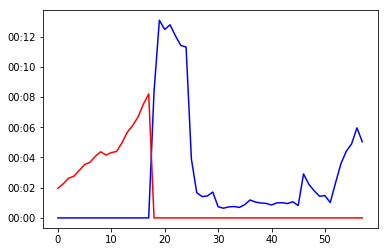

In [47]:
tt = range(num_laps)

fig, ax = plt.subplots();

plt.plot(tt, ham_diff, color="blue")
plt.plot(tt, vet_diff, color="red")

formatter = FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
ax.yaxis.set_major_formatter(formatter)

plt.show()

Try the same for all drivers

In [146]:
australia  = (lap_times >>
              mask(X.raceId == 998) >>
              arrange(X.lap))

# Number of laps
num_laps = max(australia.lap)

# Drivers that finished the race
drivers = (australia >>
           mask(X.lap == num_laps) >>
           select(X.driverId))
drivers = np.unique(drivers.driverId)

# Differences
diff = {}
total_times = {}
driver_times = {}

for driver in drivers:
    diff[driver] = []
    total_times[driver] = 0
    driver_times[driver] = 0

for i in range(1,num_laps+1):
    # lt stands for lap times
    lt = (australia >> mask(X.lap==i))
    
    # Find first place
    first = lt.loc[ lt["position"].idxmin() ]["driverId"]
    
    # Get lap times
    for driver in drivers:
        driver_times[driver] = lt.loc[ lt["driverId"]==driver, "milliseconds"].values[0]
        total_times[driver] += driver_times[driver]
    
    # Calculate differences
    for driver in drivers:
        diff[driver].append(np.abs(total_times[first] - total_times[driver]))

In [6]:
lt.loc[ lt["position"].idxmin() ]

raceId               998
driverId              20
lap                   52
position               1
time            1:31.594
milliseconds       91594
Name: 9773, dtype: object

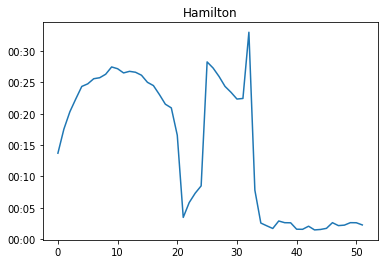

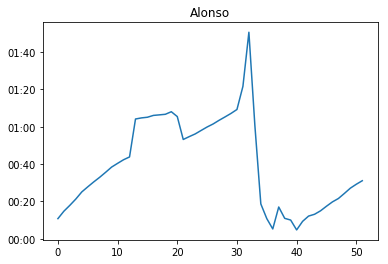

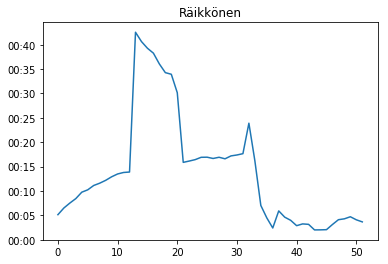

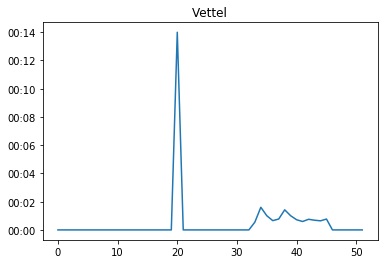

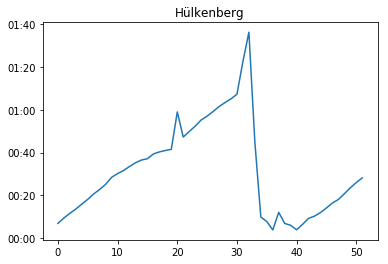

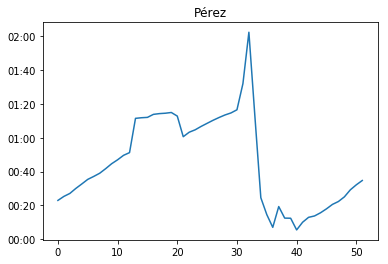

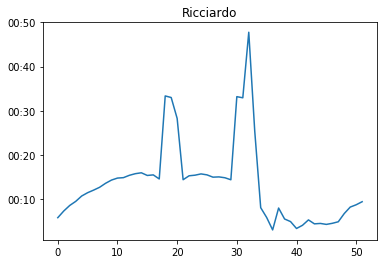

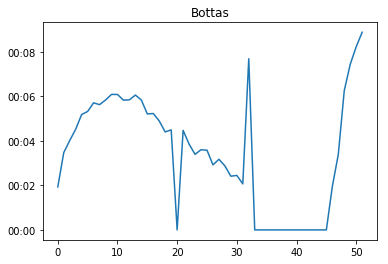

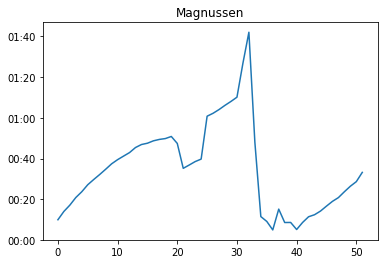

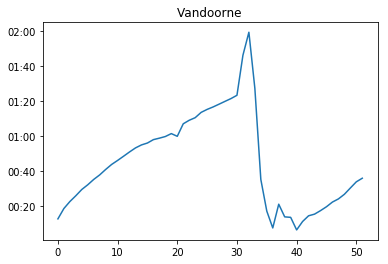

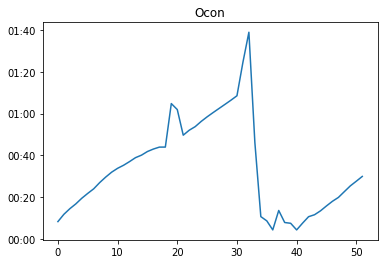

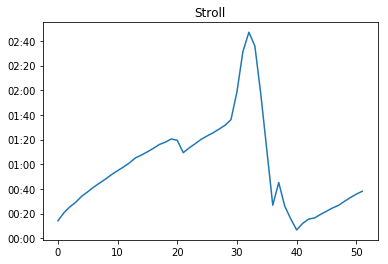

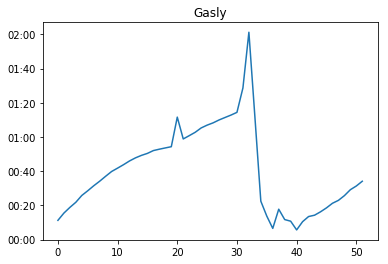

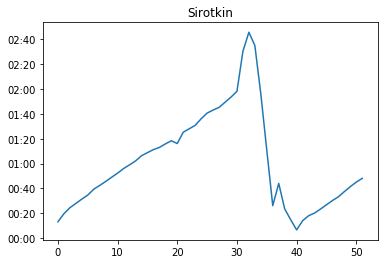

In [10]:
# Plot all differences
tt = range(num_laps)
formatter = FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))

for driver in drivers:
    fig, ax = plt.subplots();

    plt.plot(tt, diff[driver])
    plt.title(driver_name(driver))
    
    ax.yaxis.set_major_formatter(formatter)

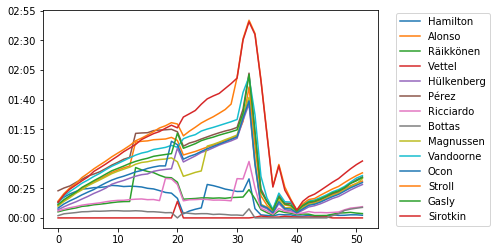

In [8]:
# Plot all differences in the same graph
# Plot all differences
tt = range(num_laps)
formatter = FuncFormatter(lambda ms, x: time.strftime('%M:%S', time.gmtime(ms // 1000)))
fig, ax = plt.subplots();

for driver in drivers:
    plt.plot(tt, diff[driver], label=driver_name(driver))
    
    ax.legend(loc='center right', bbox_to_anchor=(1.35, 0.5))
    
    ax.yaxis.set_major_formatter(formatter)

## Try to define a distance
IDEA: Turn this into a function. Calculate the difference between two drivers.

NEXT: In one race, calculate the distance as the sum of squared differences.

In [173]:
def lap_differences(driver1, driver2, raceId):
    # Gives a list with the difference lap times of driver1 minus those of driver2
    race_times  = (lap_times >>
                   mask(X.raceId == raceId, (X.driverId==driver1) | (X.driverId==driver2)) >>
                   arrange(X.lap))

    # Get times for each driver
    times1 = (race_times >>
              mask(X.driverId==driver1) >>
              select(X.milliseconds, X.lap))
    
    times2 = (race_times >>
              mask(X.driverId==driver2) >>
              select(X.milliseconds, X.lap))
    
    # Get the laps that they both did
    laps1 = max(times1.lap)
    laps2 = max(times2.lap)
    minlaps = min(laps1, laps2)

    # The difference
    diff = np.array((times1.milliseconds).add(-times2.milliseconds.values))
    
    # Turn it into seconds (not milliseconds) before returning
    return(diff/1000)

def delta_per_lap(driver1, driver2, raceId):
    # Get the difference in each lap time
    diff = lap_differences(driver1, driver2, raceId)
    
    # To get the difference on track, do the cumulative sum
    delta = [0]
    for i in range(len(diff)):
        delta.append( delta[i]+diff[i] )
    
    return(np.array(delta))

def sum_of_squares(vector):
    return(np.sum(np.square(np.array(vector))))

def mse(vector):
    return(np.mean(np.square(np.array(vector))))

The above functions match the calculations we'd done before (but have a slight offset).

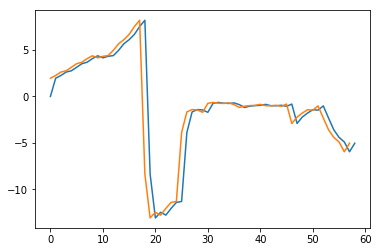

In [134]:
delta = delta_per_lap(1,20,989)

plt.plot(-np.array(delta))
plt.plot((-np.array(ham_diff) + np.array(vet_diff))/1000)

Now, let's try to do some clustering on a single race with the drivers that finished

In [247]:
def race_distances(raceId):
    # Get the drivers that finished in this race
    race_times  = (lap_times >>
                   mask(X.raceId == raceId) >>
                   arrange(X.lap))

    # Number of laps
    num_laps = max(race_times.lap)

    # Drivers that finished the race (sort them by position)
    drivers = (race_times >>
               mask(X.lap == num_laps) >>
               arrange(X.position) >>
               select(X.driverId))

    drivers = drivers.driverId.values
    _, idx = np.unique(drivers, return_index=True)
    drivers = drivers[np.sort(idx)]
    
    #print([driver_name(id) for id in drivers])
    


    # Get all distances
    distances = []
    for i in range(len(drivers)):
        row = []
        for j in range(len(drivers)):
            driveri = drivers[i]
            driverj = drivers[j]

            row.append( mse(delta_per_lap(driveri, driverj, raceId)) )

        distances.append(row)

    distances = np.array(distances)
    return(distances, drivers)

/home/MRGomez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


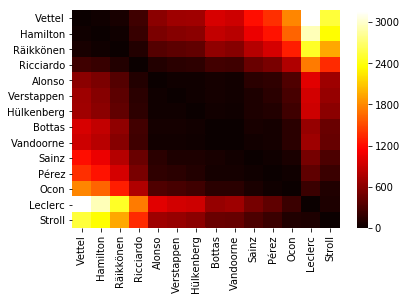

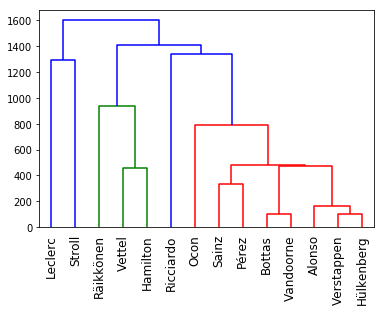

In [251]:
distances, drivers = race_distances(989)
names = [driver_name(id) for id in drivers]

sns.heatmap(distances, cmap="hot",
            xticklabels=names, yticklabels=names)

plt.figure()
linked = linkage(distances);
diag = dendrogram(linked, labels=names, leaf_rotation=90)

In [240]:
race_times  = (lap_times >>
               mask(X.raceId == 989) >>
               arrange(X.lap))

# Number of laps
num_laps = max(race_times.lap)

# Drivers that finished the race (sort them by position)
drivers = (race_times >>
           mask(X.lap == num_laps) >>
           arrange(X.position) >>
           select(X.driverId))

In [246]:
drivers.driverId.values

array([ 20,   1,   8, 817,   4, 830, 807, 822, 838, 832, 815, 839, 844,
       840])